# Introduction 

Before working on this notebook, please make sure you have correctly set up the conda environment with all requisite packages, and that you have at least one molecular editor, such as PyMOL or MOE, installed that allows you to conveniently visualize our starting protein structure. Also, there should be the `GFP_SSRL_final.pdb` and `6jgi.pdb` files in the folder. The goal of this notebook is to introduce how to clean up the initial protein structure (from our lab's x-ray diffraction experiments) before we construct the crystal system for MD simulation. There are five 
issues that we need to take care of for our eGFP protein:

* Missing OXT (terminal oxygen) on Thr230. 
* Incorrect tyrosyl protonation state at the chromophore (Cro66).
* Missing CONECT record for the chromophore in the PDB file.
* Some uncertain protonation states for charged residues (Asp, Glu, Lys, Arg, His).
* Protonate the surface and structural waters resolved from crystallography.

We will take care of these points one by one, explaining the subtleties along the way. Although I originally performed some of these tasks in GUI environments, I now try to do these by python codes just to make everything fully reproducible. 

# Step 1: Fix the missing OXT on Thr230.

Let us fire up Coot and visualize the electron density map at the C-terminus of our eGFP structure. We can see that the side chain has clear density but the carboxylic acid group does not, i.e., the OXT atom is missing. If we try to visualize the structure with PyMol we'd see weird bonding pattern there. But this is easy to fix with PDBFixer which can automatically detect missing heavy atom from the chain termini. The snippet in the next code cell will take in the starting structure `GFP_SSRL_final.pdb` and produces an intermediate file `GFP_SSRL_final_1.pdb`. We will serially process the intermediate files until we reach at `lab_fixed.pdb` in the end.

<br/><br/>

<div>
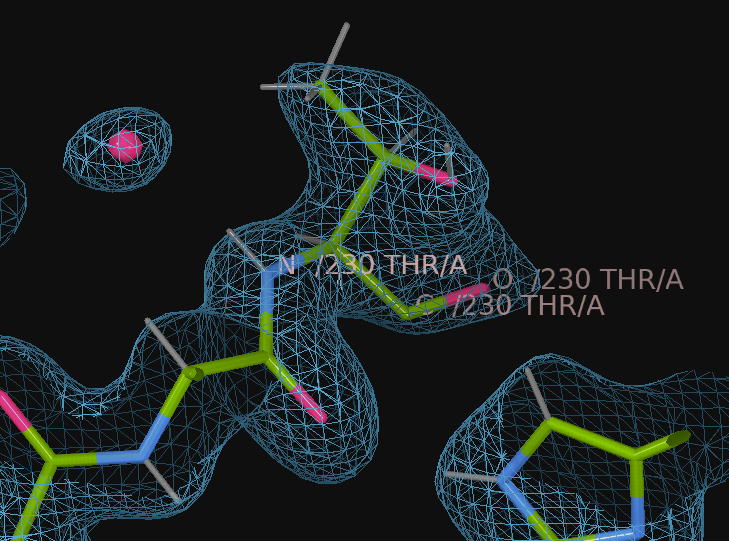
</div>
<p><center>
Figure 1: Electron density map at Thr230, contour level at rmsd=0.7
</center></p>



In [1]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile

fname = 'GFP_SSRL_final'

egfp = PDBFixer(filename=f'{fname}.pdb')
egfp.findMissingResidues()
egfp.findMissingAtoms()
egfp.addMissingAtoms()
PDBFile.writeFile(egfp.topology, egfp.positions, open(f'{fname}_1.pdb', 'w'), keepIds=True) # keepIds=True to not renumber resid ids

# Step 2: Modify the protonation state at the chromophore

Okay, let me just cite this paragraph from Takaba et al. to explain a bit about the biochemistry of eGFP:

> Green fluorescent protein (GFP), which was discovered in the
jellyfish Aequorea victoria, is a light-emitting protein consisting
of 238 amino acids. GFP absorbs UV–blue light and emits
green light. The structure consists of an 11-stranded $\beta$-barrel
plugged by a chromophore [Fig. 1(a)]. The chromophore is
4-(p-hydroxybenzylidene)imidazolin-5-one, which is formed
from three intrinsic residues (Ser65, Tyr66 and Gly67) in the
polypeptide chain by a post-translational cyclization, dehydration
and oxidation. **There are dual protonation states of the
hydroxybenzyl (tyrosyl) group of the chromophore in the
protein. The protonated neutral ‘A’ and deprotonated anionic
‘B’ forms [Fig. 1(b)] are present at ratios of 6:1 to 4:1 in wildtype
GFP (Brejc et al., 1997; Chattoraj et al., 1996). The two
forms have distinct spectroscopic properties (Chattoraj et al.,
1996). The absorption peak at 398 nm belongs to the A-form
chromophore, while the peak at 475 nm belongs to the B form
[Supplementary Fig. S1(a)].**

<div>
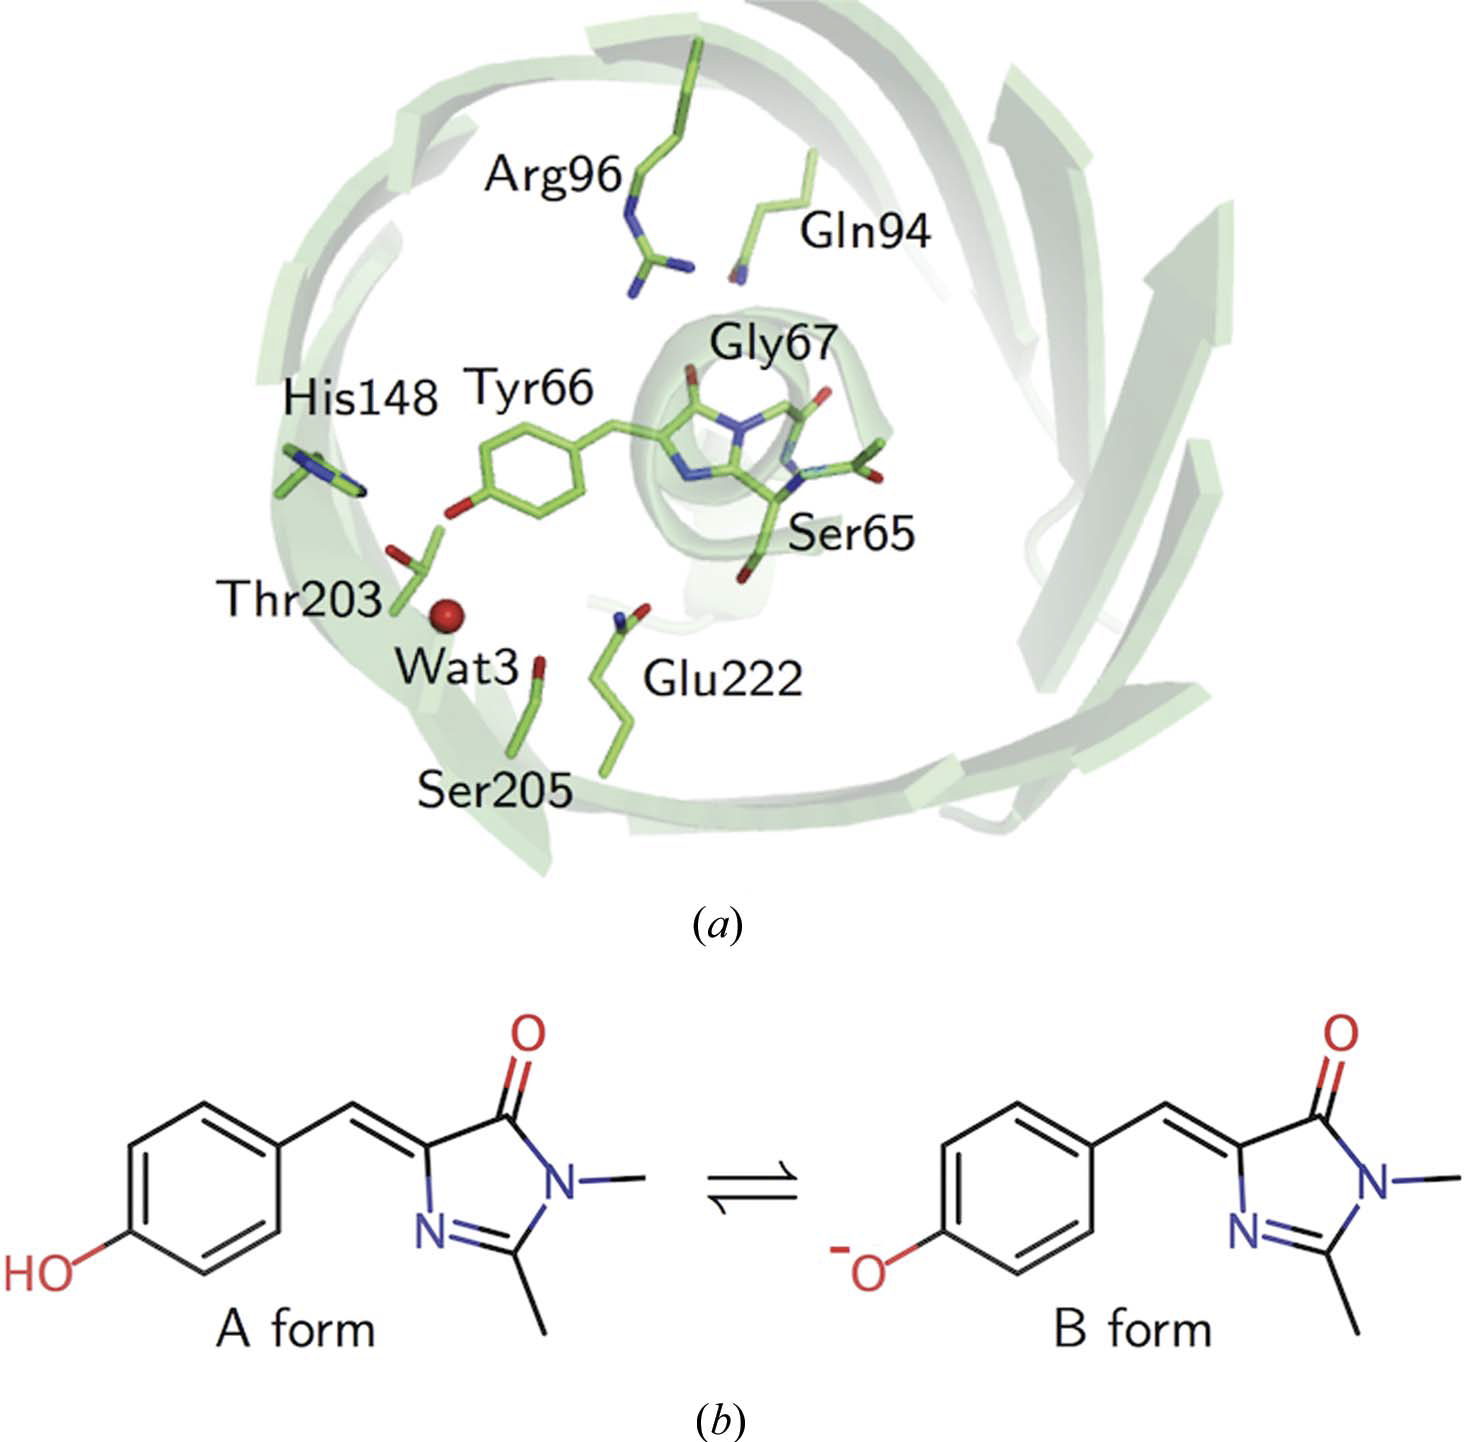
</div>

<p><center>
Figure 2: The structure of GFP from A. victoria and the dual protonation states of the chromophore.
</center></p>


So the idea is that the original GFP has dual protonation states of the chromophore, but in eGFP the deprotonated, cationic state is dominant (can see that from the excitation spectrum). In our lab structure, we didn't have any density for to support protonation/deprotonation for the chromophore (cite Jack from Slack, June 24). However, since we are using eGFP, we can confidently set the chromophore to the cationic state by stripping away a hydrogen. This is handled by using the python package for pymol. 

# Step 3: Add the missing CONECT record for the chromophore
Now a bit about bioinformatics...I will cite this from PDB spec that you can find online: 
> The CONECT records specify connectivity between atoms for which coordinates are supplied. The connectivity is described using the atom serial number as shown in the entry. CONECT records are mandatory for HET groups (excluding water) and for other bonds not specified in the standard residue connectivity table.

Hence, we must add these records for the chromophore, or in the later step, OpenMM will not be able to build the correct topology for the chromophore when we construct the crystal system. Fortunately, by reading/saving the PDB file  using pymol we can get the records added for free. How easy is that?!

Note: the `pdb_use_ter_records` line suppresses adding `TER`, otherwises pymol erroneously denote Leu64 as a terminus because there's a jump from Leu64 to Cro66 in the original numbering. The missing `TER`s should not affect subsequent steps in this tutorial, although the resulting file is not exactly PDB format compliant because the format requires a `TER` at the C-terminus of a protein. Anyway, if we do not suppress adding `TER`, then we need to manually remove the first occurent after Leu64.

In [5]:
from pymol import cmd
cmd.set('pdb_retain_ids', 1) # so it doesn't mess up our residue ids
cmd.load(f'{fname}_1.pdb', 'egfp')
cmd.select('sele', 'n. HOH and i. 66')
cmd.remove('sele')
cmd.set('pdb_use_ter_records', 0)
cmd.save(f'{fname}_2.pdb', 'egfp')

# Step 4: Modify protonation states for charged residues

Although in our experiment the pH is set at 6.5, we probably should use the protonation state reported from the S65T variant studied by Takaba et al. at pH 8.5. The reason is that their sequence is mostly the same as ours, and they have ultrahigh resolution data for electron density map, resolved at 0.8Å. The procedure I used here to avoid manual tweaking of protonation state consists of three steps: 
1. For the reference structure (6jgi) and the target structure (ours), determine the protonation variant for each residue by looking for particular atoms in the topology. We need to do this because an annoying issue with PDB format is that the three-letter amino acid code does not need to reflect the actual protonation variant specified by the residue topology.

2. Do a sequence alignment, i.e., find the longest common subsequence between two sequences via dynamic programming and return tuples of matching indices. Note the input sequences must for each amino acid aliase all variant codes to one unified code.

3. Transfer the protonation variant from the reference structure to the target structure when the matching residues have different protonation states. But to do this easily on OpenMM's topology, we need to use its modeller to add hydrogen, and we need to pass in a list of "masks" (see OpenMM's documentation if this sounds confusing, it is). 

I'll probably convert the next block of code to a tool function to be included in MDTools if I have time to test it on more examples to make sure it's always sensible to follow the steps I described above. As far as I know, there's no existing tool for doing this protonation state transfer. 

# Step 5: Protonate waters resolved from crystallography
Well, hydrogen atoms only have one electron each and these density are strongly skewed by the polar bonds they make to other electronegative atoms, so that's a quick justification of why it's very hard to see them in conventional X-ray crystallography methods. But we have a bunch of resolved waters (inferred from oxygen electron density), some on the surface, and the others are in the protein. We use OpenMM's modeller to automatically handle adding hydrogens. Hopefully there won't be any extremely offensive clash. For other possible clashes, we will relax them first when building the crystal system for MD. A valid question to raise here if we should add hydrogens more carefully to the structural water inside eGFP because, as we know, hydrogen bonds are highly directional. That's a detail I haven't taken care of yet now and it doesn't seem to affect the subsequent analyses.

In [45]:
from openmm.app.modeller import Modeller
from openmm.app.pdbfile import PDBFile
from functools import lru_cache

src_chain_ids = {0: 0}

src_dir = '6jgi.pdb'
tgt_dir = f'{fname}_2.pdb'
out_dir = f'lab_fixed.pdb'
forcefield = None

egfp = PDBFixer(filename=f'{fname}.pdb')
egfp.findMissingResidues()
egfp.findMissingAtoms()
egfp.addMissingAtoms()
PDBFile.writeFile(egfp.topology, egfp.positions, open(f'{fname}_1.pdb', 'w'))

src = PDBFile(src_dir)
tgt = PDBFile(tgt_dir)

assert len(src_chain_ids)==len(tgt_chain_ids), "You must provide a matching number of chains in the source and target structures!"
assert max(src_chain_ids) <= src.topology.getNumChains()-1 and \
       max(tgt_chain_ids) <= tgt.topology.getNumChains()-1, "You must provide chain ids in the valid ranges!"

# default residue names to the neutral variant (aliasing)
# but this doesn't work as I realize that PDBFile does not store residue variant, 
# need to do the checking by my self
mapping = {'ASH': 'ASH', 'ASP': 'ASH', 'CYS': 'CYS', 'CYX': 'CYS', 'GLH': 'GLH', 'GLU': 'GLH', 
           'HID': 'HID', 'HIE': 'HID', 'HIP': 'HID', 'HIN': 'HID', 'LYN': 'LYN', 'LYS': 'LYN'}
def get_default_resid_name(n):
    if n in mapping:
        return mapping[n]
    else:
        return n

# find longest common subsequence, return tuples of indices of matching elements from the two seqs
def lcs(seq1, seq2):
    @lru_cache(maxsize=None)
    def helper(idx1 = 0, idx2 = 0):
    
        if idx1 == len(seq1) or idx2 == len(seq2):
            return []
            
        if seq1[idx1] == seq2[idx2]:
            return  [(idx1, idx2)] + helper(idx1 + 1, idx2 + 1)
        
        option1 = helper(idx1 + 1, idx2)
        option2 = helper(idx1, idx2 + 1)
        
        return max(option1, option2, key=len)
    
    return helper()

# returns the 3 letter amino acid residue code for the protonation variant
def assign_protonation_variants(atoms_iter, res_code):
    atom_code_lst = [a.name for a in atoms_iter]
    # check if (a) particular atom(s) appears and return the residue code if so
    def check_atom(atom_code, res_code):
        if atom_code in atom_code_lst:
            return res_code
        
    if res_code == 'ASP':
        if 'HD2' in atom_code_lst:
            return 'ASH'
        else:
            return 'ASP'
    elif res_code == 'CYS':
        if 'HG' in atom_code_lst:
            return 'CYS'
        else:
            return 'CYX'
    elif res_code == 'GLU':
        if 'HE2' in atom_code_lst:
            return 'GLH'
        else:
            return 'GLU'
    elif res_code == 'HIS':
        if 'HD1' in atom_code_lst:
            if 'HE2' in atom_code_lst:
                return 'HIP'
            else:
                return 'HID'
        elif 'HE2' in atom_code_lst:
            return 'HIE'
        else:
            return 'HIN'
    elif res_code == 'LYS':
        if 'HZ1' in atom_code_lst:
            return 'LYS'
        else:
            return 'LYN'
    # either the residue has been already assigned a protonation variant
    # or for the remaining amino acids there's no alternative protonation states possible
    else:
        return res_code
    
full_mask = []
for tgt_chain_id, tgt_chain in enumerate(tgt.topology.chains()):
    mask = [None] * len(list(tgt_chain.residues()))
    src_chain_id = src_chain_ids.get(tgt_chain_id)
    if src_chain_id is not None:
        src_chain = nth(src.topology.chains(), src_chain_id)
        tgt_chain = nth(tgt.topology.chains(), tgt_chain_id)
        src_resids = [assign_protonation_variants(resid.atoms(), resid.name) for resid in src_chain.residues()]
        tgt_resids = [assign_protonation_variants(resid.atoms(), resid.name) for resid in tgt_chain.residues()]
        for src_idx, tgt_idx in lcs([get_default_resid_name(n) for n in src_resids], 
                                    [get_default_resid_name(n) for n in tgt_resids]):
            if src_resids[src_idx] in mapping:
                mask[tgt_idx] = src_resids[src_idx]
    full_mask += mask

tgt_modeller = Modeller(tgt.topology, tgt.positions)
tgt_modeller.addHydrogens(forcefield, variants = full_mask)
PDBFile.writeFile(tgt_modeller.topology, tgt_modeller.positions, open(out_dir, 'w'))

Finally, let us see for which residues we have modified the protonation state of our lab structure to match that of the 6jgi structure.

In [46]:
for i, tup in enumerate(zip(full_mask, tgt_resids)):
    mask, tgt_resid = tup
    if mask is not None and mask != tgt_resid:
        print(f'Residue {i} changed from {tgt_resid} to {mask}.')

Residue 25 changed from HIE to HID.
Residue 48 changed from CYS to CYX.
Residue 75 changed from HIE to HID.
Residue 79 changed from HIE to HIP.
Residue 129 changed from LYS to LYN.
Residue 138 changed from LYS to LYN.
Residue 146 changed from HID to HIP.
Residue 154 changed from LYS to LYN.
Residue 156 changed from LYS to LYN.
Residue 220 changed from GLU to GLH.


Here's a useful figure for reference, describing the protonation variants, their name, code, and structure, for the charged amino acids. It's used to code the `assign_protonation_variants` function I used above.

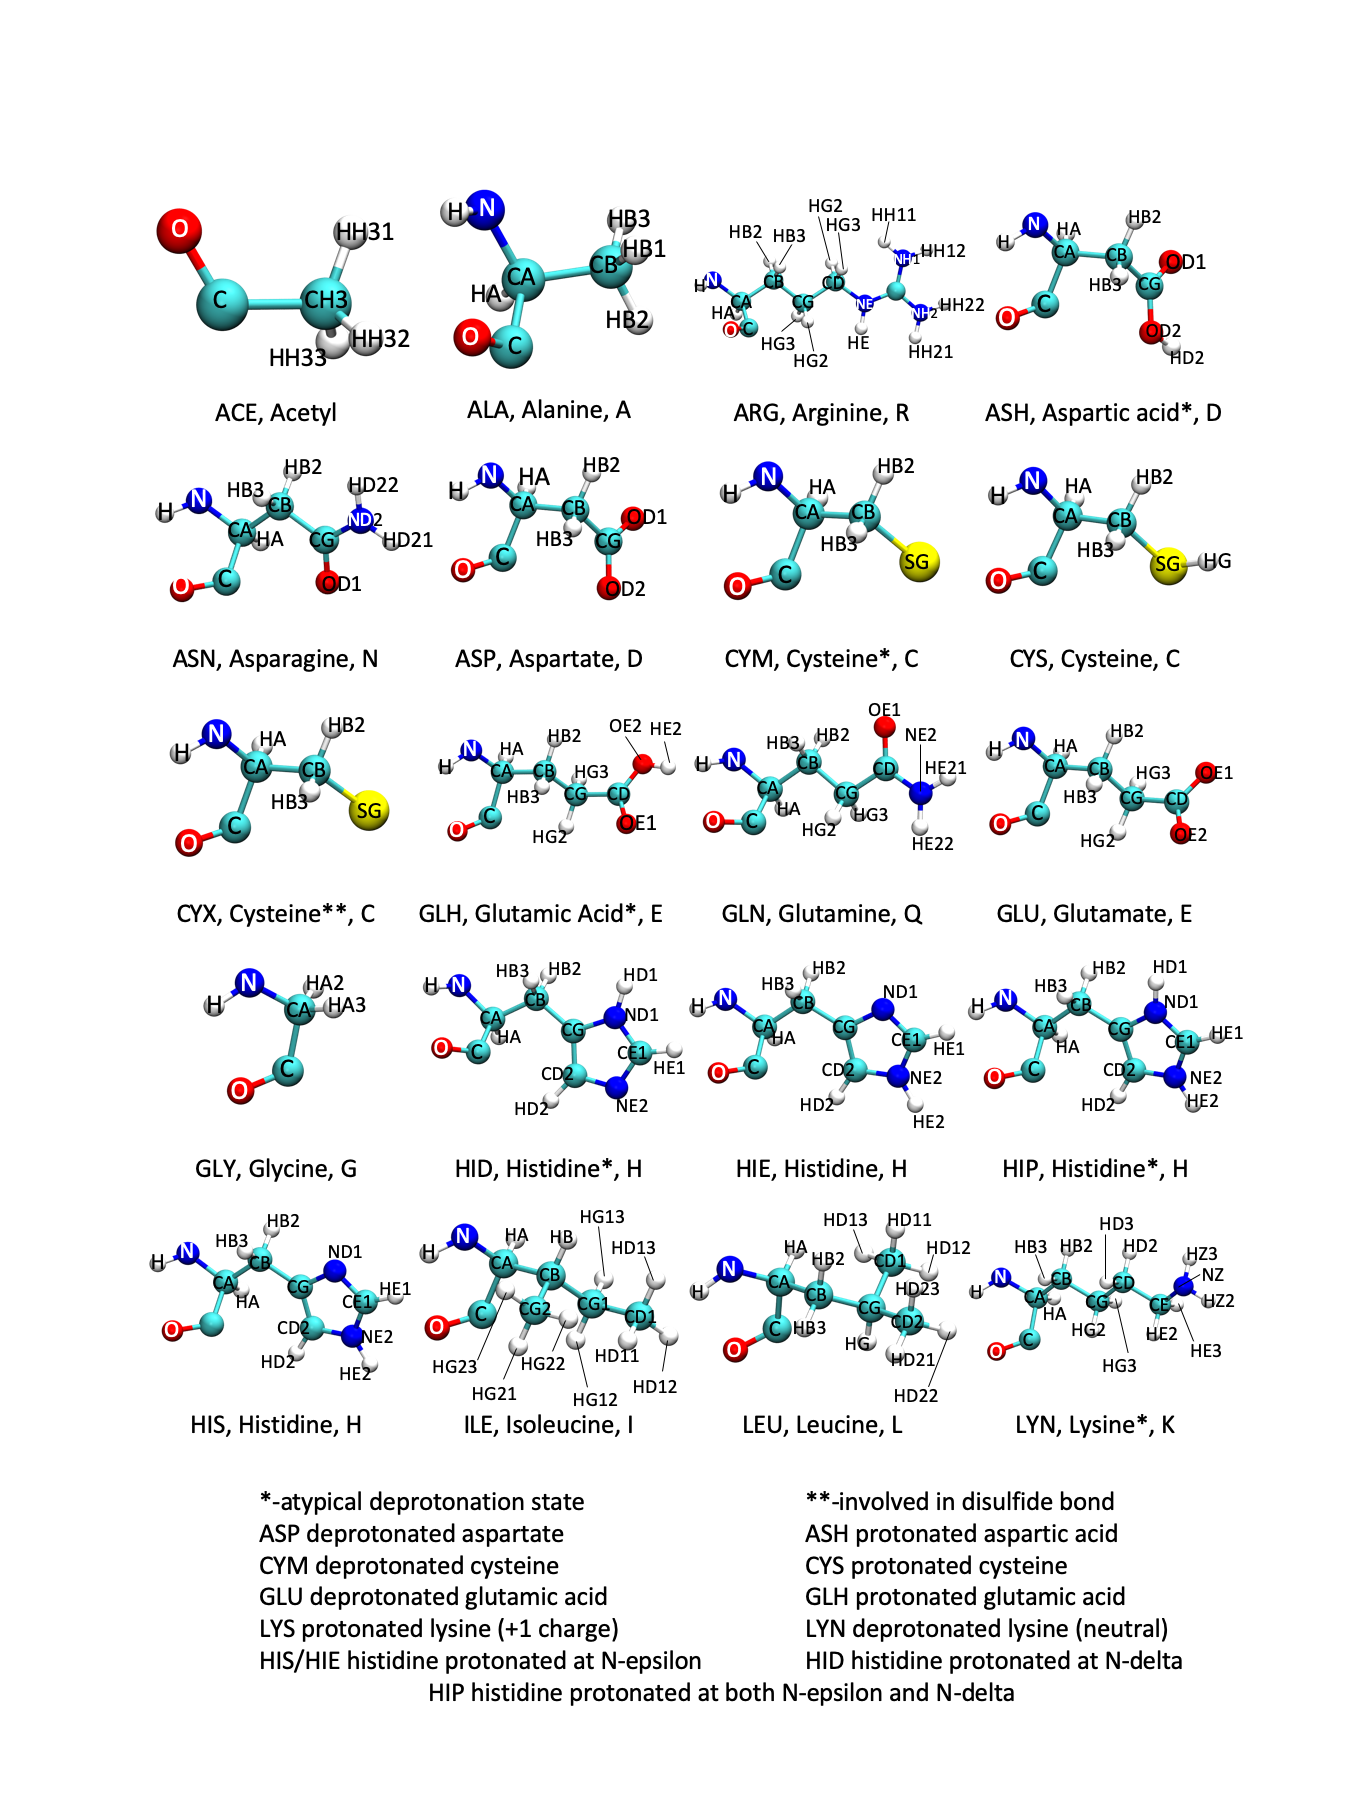